### PYMC


In [430]:
import pymc as pm
import numpy as np
import matplotlib.pyplot as plt
import seaborn

http://nbviewer.ipython.org/github/CamDavidsonPilon/Probabilistic-Programming-and-Bayesian-Methods-for-Hackers/blob/master/Chapter2_MorePyMC/Chapter2.ipynb

### Random var

In [40]:
parameter = pm.Exponential("poisson_param", 1)
data_generator = pm.Poisson("data_generator", parameter)
data_plus_one = data_generator + 1

In [222]:
data_generator.random()
data_generator.value

array(1)

In [232]:
data_generator.value += 1
data_plus_one.value

ValueError: output array is read-only

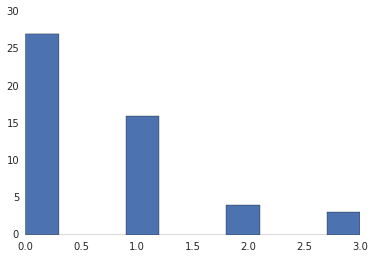

In [174]:
%matplotlib inline
Y = [data_generator.random() for _ in X]
_ = plt.hist(Y)

### Go

In [281]:
lambda_1 = pm.Exponential("lambda_1", 1)  # prior on first behaviour
lambda_2 = pm.Exponential("lambda_2", 1)  # prior on second behaviour
tau = pm.DiscreteUniform("tau", lower=0, upper=10)  # prior on behaviour change

print "lambda_1.value = %.3f" % lambda_1.value
print "lambda_2.value = %.3f" % lambda_2.value
print "tau.value = %.3f" % tau.value
print

lambda_1.random(), lambda_2.random(), tau.random()

print "After calling random() on the variables..."
print "lambda_1.value = %.3f" % lambda_1.value
print "lambda_2.value = %.3f" % lambda_2.value
print "tau.value = %.3f" % tau.value

lambda_1.value = 1.314
lambda_2.value = 1.934
tau.value = 3.000

After calling random() on the variables...
lambda_1.value = 0.962
lambda_2.value = 2.217
tau.value = 3.000


In [283]:
import numpy as np
n_data_points = 5  # in CH1 we had ~70 data points


@pm.deterministic
def lambda_(tau=tau, lambda_1=lambda_1, lambda_2=lambda_2):
    out = np.zeros(n_data_points)
    out[:tau] = lambda_1  # lambda before tau is lambda1
    out[tau:] = lambda_2  # lambda after tau is lambda2
    return out

In [288]:
data = np.array([10, 25, 15, 20, 35])
obs = pm.Poisson("obs", lambda_, value=data, observed=True)

In [286]:
model = pm.Model([obs, lambda_, lambda_1, lambda_2, tau])

### Same story; different ending 

In [289]:
tau = pm.rdiscrete_uniform(0, 80)
print tau

42


In [290]:
alpha = 1. / 20.
lambda_1, lambda_2 = pm.rexponential(alpha, 2)
print lambda_1, lambda_2

43.447308921 20.9075243741


In [299]:
data = np.r_[pm.rpoisson(lambda_1, tau), pm.rpoisson(lambda_2, 80 - tau)]

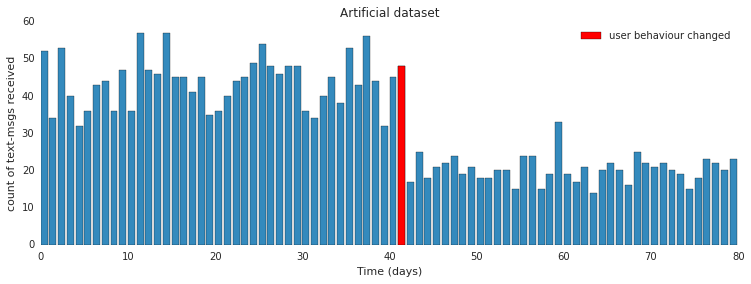

In [416]:
plt.bar(np.arange(80), data, color="#348ABD")
plt.bar(tau - 1, data[tau - 1], color="r", label="user behaviour changed")
plt.xlabel("Time (days)")
plt.ylabel("count of text-msgs received")
plt.title("Artificial dataset")
plt.xlim(0, 80)
plt.legend();

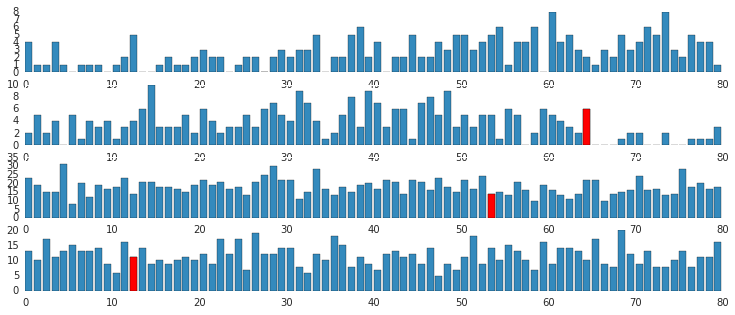

In [417]:
def plot_artificial_sms_dataset():
    tau = pm.rdiscrete_uniform(0, 80)
    alpha = 1. / 20.
    lambda_1, lambda_2 = pm.rexponential(alpha, 2)
    data = np.r_[pm.rpoisson(lambda_1, tau), pm.rpoisson(lambda_2, 80 - tau)]
    plt.bar(np.arange(80), data, color="#348ABD")
    plt.bar(tau - 1, data[tau - 1], color="r", label="user behaviour changed")
    plt.xlim(0, 80)

figsize(12.5, 5)
plt.title("More example of artificial datasets")
for i in range(4):
    plt.subplot(4, 1, i)
    plot_artificial_sms_dataset()

### Bayesian A/B testing

In [418]:
import pymc as pm

# The parameters are the bounds of the Uniform.
p = pm.Uniform('p', lower=0, upper=1)

In [420]:
# set constants
p_true = 0.05  # remember, this is unknown.
N = 1500

# sample N Bernoulli random variables from Ber(0.05).
# each random variable has a 0.05 chance of being a 1.
# this is the data-generation step
occurrences = pm.rbernoulli(p_true, N)

print occurrences  # Remember: Python treats True == 1, and False == 0
print occurrences.sum()

[False False False ..., False False False]
65


In [421]:
# Occurrences.mean is equal to n/N.
print "What is the observed frequency in Group A? %.4f" % occurrences.mean()
print "Does this equal the true frequency? %s" % (occurrences.mean() == p_true)

What is the observed frequency in Group A? 0.0433
Does this equal the true frequency? False


In [422]:
# include the observations, which are Bernoulli
obs = pm.Bernoulli("obs", p, value=occurrences, observed=True)

# To be explained in chapter 3
mcmc = pm.MCMC([p, obs])
mcmc.sample(18000, 1000)

 [-----------------100%-----------------] 18000 of 18000 complete in 1.0 sec

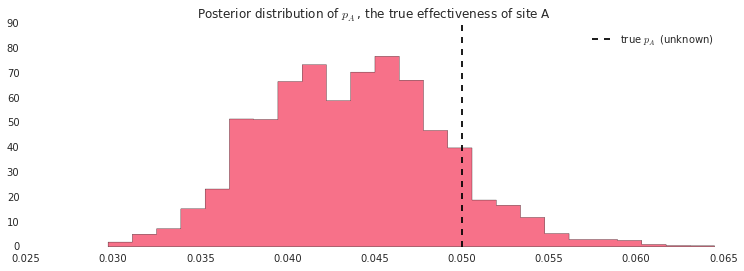

In [431]:
figsize(12.5, 4)
plt.title("Posterior distribution of $p_A$, the true effectiveness of site A")
plt.vlines(p_true, 0, 90, linestyle="--", label="true $p_A$ (unknown)")
plt.hist(mcmc.trace("p")[:], bins=25, histtype="stepfilled", normed=True)
plt.legend()

In [435]:
mcmc.trace("p")[:]

array([ 0.05494611,  0.05494611,  0.05494611, ...,  0.03845467,
        0.03845467,  0.03845467])